In [ ]:
import pandas as pd
from pandas import unique
import sys
from pathlib import Path
import pathlib

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from utils.new_columns_fiorenzo import add_speed_direction_to_summary, pixel_meters_ratio, add_day_night_to_summary, classify_vehicle_types
from utils.plots_fiorenzo import visualize_classification, vehicle_count_by_category_bar_chart, average_speed_by_weekday_and_hour, speeding_vehicles_histogram, speed_category_bar_chart
from data_pipeline import process_all_sessions
from utils.loader import load_data_from_database

In [22]:
final_summary = None
summary_loaded = False

csv_path = Path('../data/processed_traffic_data.csv')

if csv_path.exists():
    print(f"Found {csv_path.name}. Do you want to load it?")
    if input("Type 'y' to proceed: ").lower() == 'y':
        final_summary = pd.read_csv(csv_path)
        summary_loaded = True
        print(f"✓ Successfully loaded {len(final_summary)} records from {csv_path.name}")
else:
    print(f"File {csv_path} not found.")
    print("Automatically loading data from database...")

File ../data/processed_traffic_data.csv not found.
Automatically loading data from database...


In [ ]:
if not summary_loaded:
    # If processed file doesn't exist, load from database automatically
    # or use raw CSV as fallback if database connection fails
    try:
        df = load_data_from_database()
        df = df.sort_values(['date_time', 'frame_id'])
        print(f"✓ Successfully loaded {len(df)} records from database")
    except Exception as e:
        print(f"Database connection failed: {e}")
        raw_csv_path = Path("../data/raw_traffic_data.csv")
        if raw_csv_path.exists():
            print(f"Loading from {raw_csv_path.name} as fallback...")
            df = pd.read_csv(raw_csv_path, parse_dates=['date_time'])
            df = df.sort_values(['date_time', 'frame_id'])
            print(f"✓ Loaded {len(df)} records from CSV")
        else:
            raise FileNotFoundError(f"Neither database connection nor {raw_csv_path} is available")

Connection established successfully!


/Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/utils/loader.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


Loaded 11130425 records
Data saved to /Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/data/raw_traffic_data.csv
✓ Connection closed
✓ Successfully loaded 11130425 records from database


In [24]:
if not summary_loaded:
    df['session_id'] = (
        (df['frame_id'].diff() < 0)
    ).cumsum()

In [25]:
if not summary_loaded:
    final_summary = process_all_sessions(df)
    print(final_summary.head())
    print(unique(final_summary['category']))
    final_summary.to_csv("../data/processed_traffic_data.csv", index=False)

Processing 16 sessions...

📍 Session 1/16 (session_id=0)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          : 2396 IDs
    • Noise          :   17 IDs
    • Partial        :  190 IDs
    • Perfect        :   43 IDs

  Step 2: Finding merge pairs...
  Found pairs for merging: 1252

  Step 3: Building merge chains and consolidating...
  Built 453 chains
    • Longest chain: 41 IDs
    • Average chain length: 3.8 IDs
  ✓ Consolidated into 187 merged records
  ✓ Total records with unified_id: 369

📍 Session 2/16 (session_id=1)
--------------------------------------------------------------------------------
  Step 1: Categorizing IDs...
  Category distribution:
    • Flickering     :    1 IDs
    • Ghost          :  360 IDs
    • Noise          :    1 IDs
    • Partial        :   52 IDs
    • Perfect        :  161 IDs

  Step 2: Finding merge pairs...
  F

In [26]:
## Filter viable vehicles
final_summary = final_summary[final_summary['unified_id'].notna()]

In [27]:
## Check if directory plots exists
path = pathlib.Path("../plots")
path.mkdir(parents=True, exist_ok=True)

In [28]:
## Filter time
final_summary['t_start'] = pd.to_datetime(final_summary['t_start'])
final_summary['t_end'] = pd.to_datetime(final_summary['t_end'])

start_date = pd.to_datetime('2025-12-01')
end_date = pd.to_datetime('2026-01-01')

final_summary = final_summary[(final_summary['t_start'] >= start_date) & (final_summary['t_start'] < end_date)]
print(f"Filtered data from {start_date.date()} to {end_date.date()}")
print(f"Remaining records: {len(final_summary)}")
print(final_summary)

Filtered data from 2025-12-01 to 2026-01-01
Remaining records: 95750
        session_id                    vehicle_id  y_start  y_end      w_mean  \
21353            2                [19316, 19317]      211    147   61.500000   
21439            2  [19403, 19406, 19412, 19415]      278    162  210.614130   
21458            2                       [19425]      194    278   97.937500   
21603            2                       [19570]      269    194  149.327586   
21622            2                [19589, 19592]      192    194  215.000000   
...            ...                           ...      ...    ...         ...   
510320          15         [92467, 92470, 92473]      140    182   99.851852   
510321          15                [92468, 92471]        0      0   62.000000   
510322          15                       [92474]        0    112   84.630435   
510331          15                       [92483]      160     44   85.300000   
510332          15                       [92484]   

In [29]:
## Duration, Speed and Direction
final_summary['duration'] = (final_summary['t_end'] - final_summary['t_start']).dt.total_seconds()

final_summary = add_speed_direction_to_summary(final_summary)

print(final_summary.head())

       session_id                    vehicle_id  y_start  y_end      w_mean  \
21353           2                [19316, 19317]      211    147   61.500000   
21439           2  [19403, 19406, 19412, 19415]      278    162  210.614130   
21458           2                       [19425]      194    278   97.937500   
21603           2                       [19570]      269    194  149.327586   
21622           2                [19589, 19592]      192    194  215.000000   

           w_std  w_start  w_end     h_mean      h_std  ...      h_cv  \
21353   1.961161     66.0   59.0  21.357143   1.898525  ...  0.088894   
21439  13.277979     84.0  215.0  74.883696  20.690459  ...  0.276301   
21458  43.702771     33.0   82.0  69.687500  36.391580  ...  0.522211   
21603  26.592696    187.0  129.0  37.206897  34.759706  ...  0.934227   
21622   0.000000    215.0  215.0  97.250000   0.707107  ...  0.007271   

       movement_efficiency  category unified_id  duration  \
21353             0.02046

In [30]:
## Create columns size_mean and h/w_mean ratio
final_summary['size_mean'] = final_summary['w_mean'] * final_summary['h_mean']
final_summary['h_w_mean_ratio'] = final_summary['h_mean'] / final_summary['w_mean']
print(final_summary.head())

       session_id                    vehicle_id  y_start  y_end      w_mean  \
21353           2                [19316, 19317]      211    147   61.500000   
21439           2  [19403, 19406, 19412, 19415]      278    162  210.614130   
21458           2                       [19425]      194    278   97.937500   
21603           2                       [19570]      269    194  149.327586   
21622           2                [19589, 19592]      192    194  215.000000   

           w_std  w_start  w_end     h_mean      h_std  ...  category  \
21353   1.961161     66.0   59.0  21.357143   1.898525  ...    Merged   
21439  13.277979     84.0  215.0  74.883696  20.690459  ...    Merged   
21458  43.702771     33.0   82.0  69.687500  36.391580  ...   Partial   
21603  26.592696    187.0  129.0  37.206897  34.759706  ...   Partial   
21622   0.000000    215.0  215.0  97.250000   0.707107  ...    Merged   

       unified_id  duration velocity_x_px_seconds velocity_y_px_seconds  \
21353      

In [31]:
## Mean height, width and size in meters
final_summary['h_mean_meters'] = final_summary['h_mean'] / pixel_meters_ratio
final_summary['w_mean_meters'] = final_summary['w_mean'] / pixel_meters_ratio
final_summary['size_mean_meters'] = final_summary['size_mean'] / pixel_meters_ratio
print(final_summary)

        session_id                    vehicle_id  y_start  y_end      w_mean  \
21353            2                [19316, 19317]      211    147   61.500000   
21439            2  [19403, 19406, 19412, 19415]      278    162  210.614130   
21458            2                       [19425]      194    278   97.937500   
21603            2                       [19570]      269    194  149.327586   
21622            2                [19589, 19592]      192    194  215.000000   
...            ...                           ...      ...    ...         ...   
510318          15         [92465, 92469, 92472]       11      0  105.466667   
510320          15         [92467, 92470, 92473]      140    182   99.851852   
510322          15                       [92474]        0    112   84.630435   
510331          15                       [92483]      160     44   85.300000   
510332          15                       [92484]      272      0   51.548387   

            w_std  w_start  w_end      

In [32]:
## Day/Night difference
final_summary = add_day_night_to_summary(final_summary)
print(final_summary)

        session_id                    vehicle_id  y_start  y_end      w_mean  \
21353            2                [19316, 19317]      211    147   61.500000   
21439            2  [19403, 19406, 19412, 19415]      278    162  210.614130   
21458            2                       [19425]      194    278   97.937500   
21603            2                       [19570]      269    194  149.327586   
21622            2                [19589, 19592]      192    194  215.000000   
...            ...                           ...      ...    ...         ...   
510318          15         [92465, 92469, 92472]       11      0  105.466667   
510320          15         [92467, 92470, 92473]      140    182   99.851852   
510322          15                       [92474]        0    112   84.630435   
510331          15                       [92483]      160     44   85.300000   
510332          15                       [92484]      272      0   51.548387   

            w_std  w_start  w_end      

In [33]:
## Apply vehicle classification
# Classify vehicles using automatic data-driven thresholds
final_summary = classify_vehicle_types(final_summary, verbose=True, night_width_threshold=0)

'''
# Optional: Use custom thresholds if you want to fine-tune the classification
# Uncomment and adjust values as needed:
# final_summary_with_class = classify_vehicle_types(
#     final_summary_viable,
#     size_threshold=7500,      # Threshold for area (w_mean * h_mean)
#     width_threshold=70,        # Threshold for width
#     height_threshold=140,      # Threshold for height
#     verbose=True
# )
'''
# Show sample results
print("\n" + "="*70)
print("SAMPLE CLASSIFIED VEHICLES")
print("="*70)
print("\nFirst 10 vehicles:")
print(final_summary[['vehicle_id', 'w_mean', 'h_mean', 'size_mean', 'h_w_mean_ratio', 'Class']].head(10).to_string(index=False))

print("\n" + "="*70)
print("CLASS DISTRIBUTION BY TRACK CATEGORY")
print("="*70)
crosstab = pd.crosstab(final_summary['category'],
                       final_summary['Class'],
                       margins=True, margins_name='Total')
print(crosstab)
print("\n" + "="*70)

VEHICLE CLASSIFICATION RESULTS - DAY

Vehicles classified during Day: 50388

Classification threshold used for Day:
  Height threshold:          120.00 pixels

Class distribution for Day:
  Car   : 42517 ( 84.4%)
  Truck : 7871 ( 15.6%)

Duration threshold calculated from Day data:
  Mean Car duration:           3.63 seconds
  Mean Truck duration:         3.31 seconds
  Calculated threshold:        3.47 seconds (midpoint)

VEHICLE CLASSIFICATION RESULTS - NIGHT

Vehicles classified during Night: 28360

Classification thresholds used for Night (OR logic):
  Height threshold:          120.00 pixels
  Width threshold:             0.00 pixels
  Duration threshold:          3.47 seconds

Trucks classified by criterion:
  By height:               7202
  By width (not height):   21158
  By duration (not h/w):      0

Class distribution for Night:
  Car   : 26890 ( 94.8%)
  Truck : 1470 (  5.2%)

OVERALL CLASSIFICATION SUMMARY

Total vehicles classified: 78748

Overall class distribution:
  Ca

Total


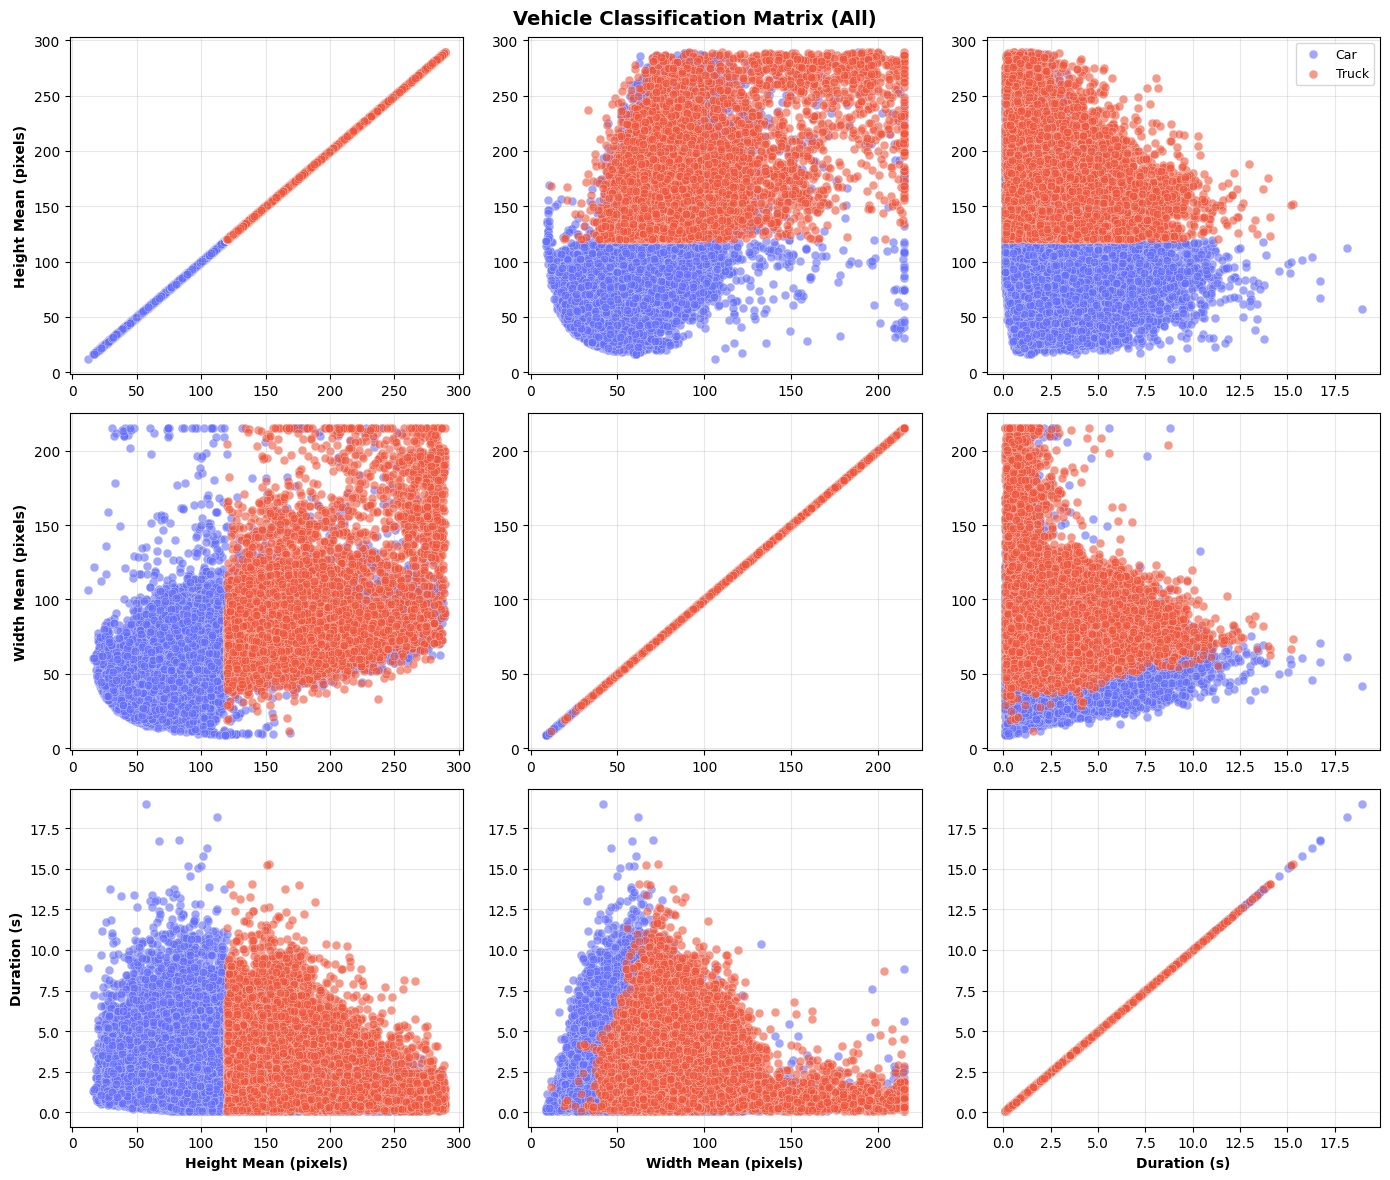


CLASSIFICATION SUMMARY (All)

Total vehicles: 78748
  Cars:   69407 (88.1%)
  Trucks: 9341 (11.9%)

Day


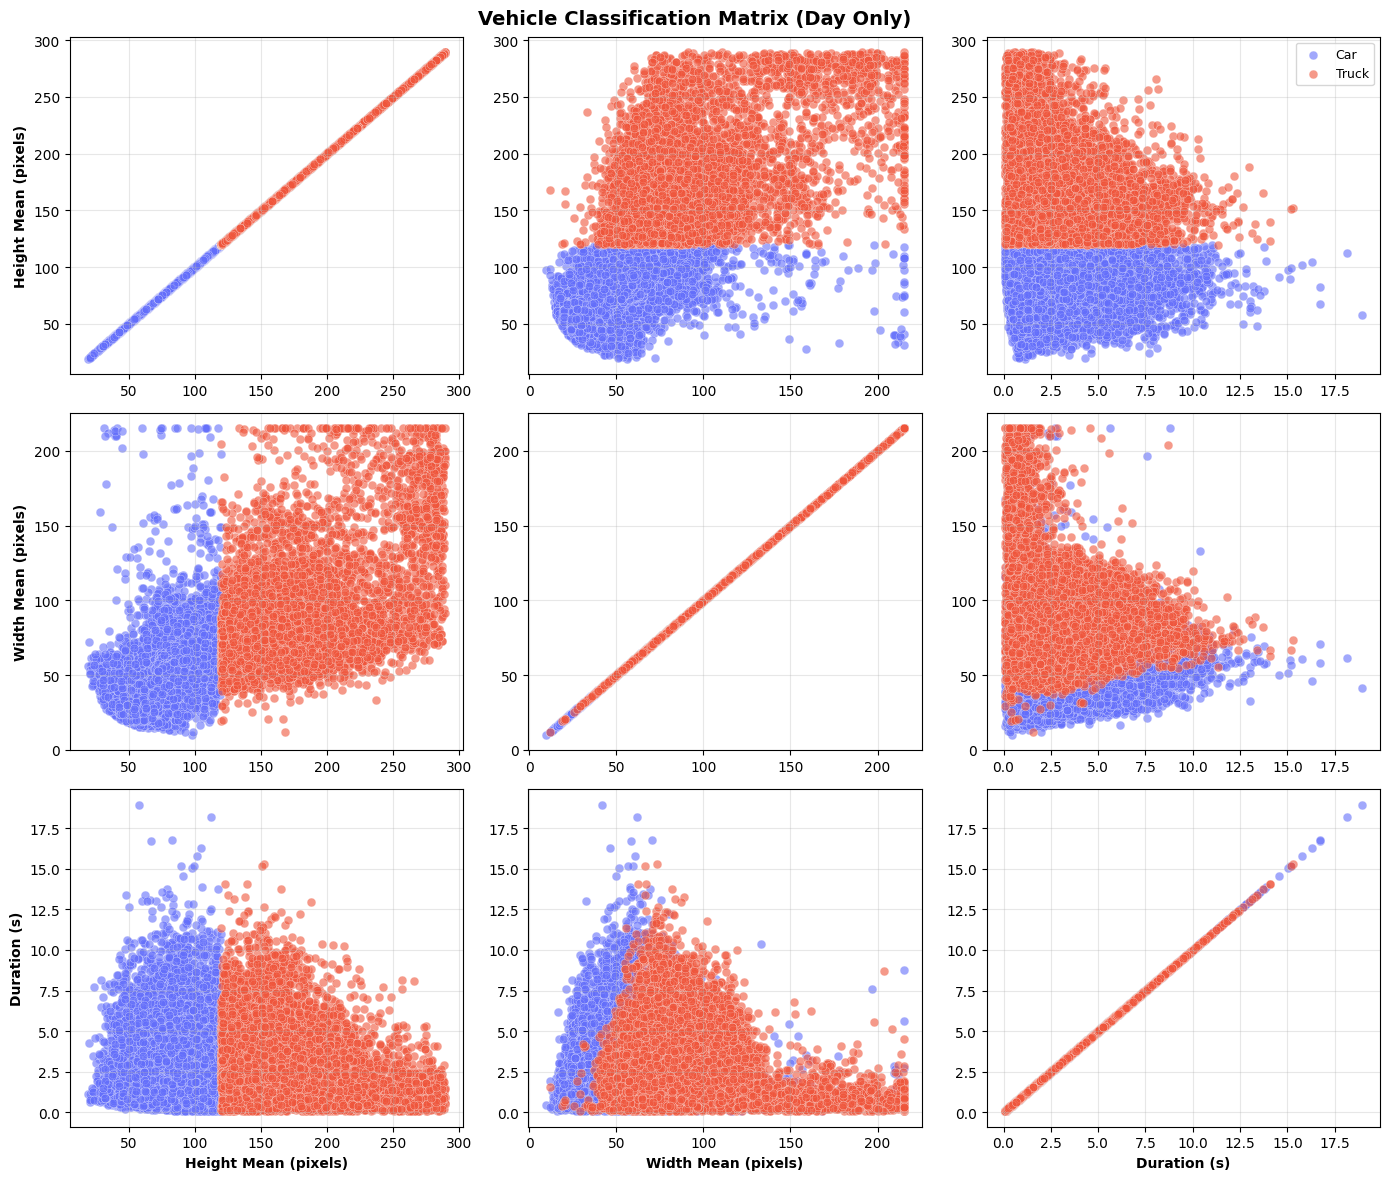


CLASSIFICATION SUMMARY (Day Only)

Total vehicles: 50388
  Cars:   42517 (84.4%)
  Trucks: 7871 (15.6%)

Night


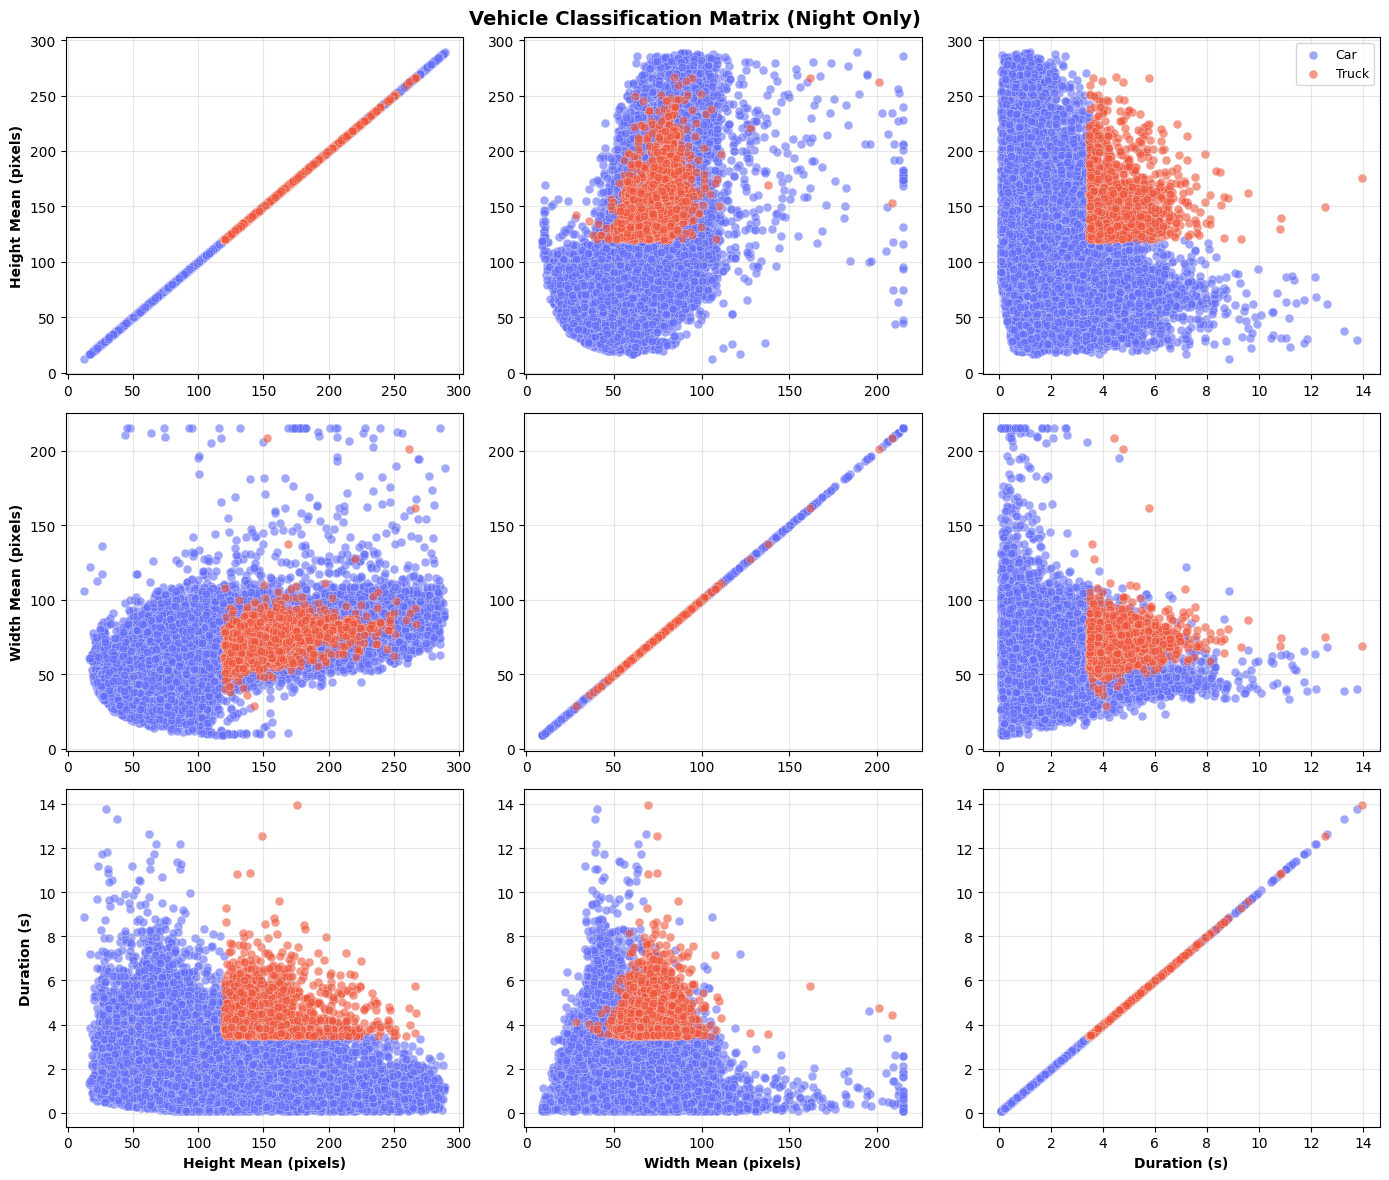


CLASSIFICATION SUMMARY (Night Only)

Total vehicles: 28360
  Cars:   26890 (94.8%)
  Trucks: 1470 (5.2%)



In [34]:
## Visualize vehicle classification
print("Total")
visualize_classification(final_summary, show_plot=True)
print("Day")
visualize_classification(final_summary, show_plot=True, day_only=True)
print("Night")
visualize_classification(final_summary, show_plot=True, night_only=True)

/Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/utils/plots_fiorenzo.py:168: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = ax.axhspan(i - 0.4, i + 0.4, alpha=0.2, color='gray',


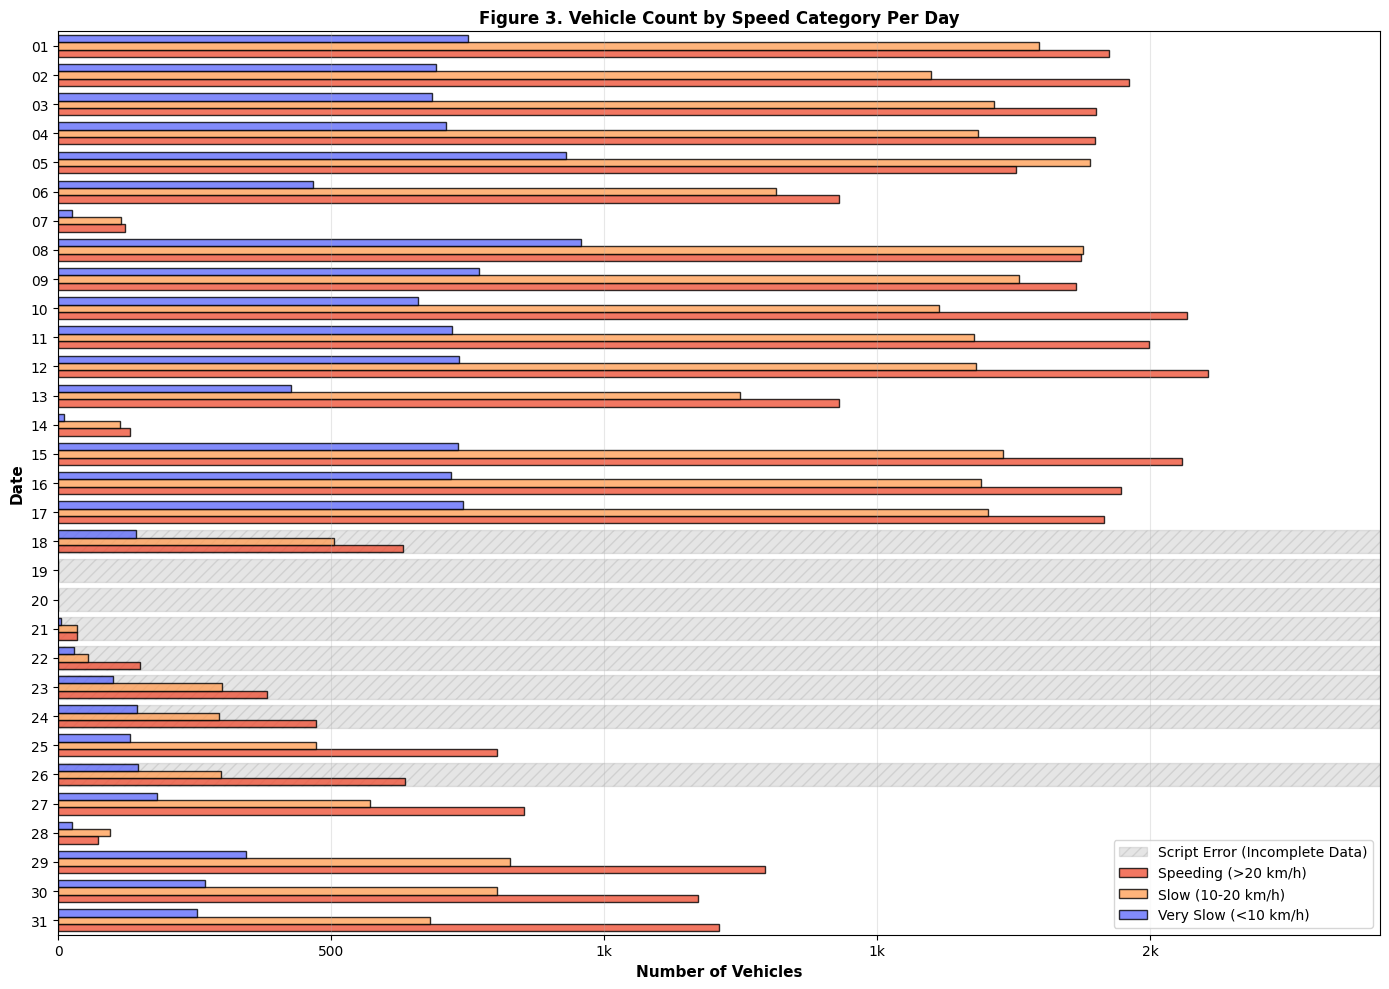

VEHICLE SPEED CATEGORY STATISTICS

Data collection period: 2025-12-31 to 2025-12-01
Total days: 31
Total vehicles: 78748

Speeding (>20 km/h):
  Total: 36093 (45.8%)
  Daily average: 1164.3
  Maximum: 2105 (on 2025-12-12)
  Minimum: 0 (on 2025-12-20)

Slow (10-20 km/h):
  Total: 30147 (38.3%)
  Daily average: 972.5
  Maximum: 1890 (on 2025-12-05)
  Minimum: 0 (on 2025-12-20)

Very Slow (<10 km/h):
  Total: 12508 (15.9%)
  Daily average: 403.5
  Maximum: 957 (on 2025-12-08)
  Minimum: 0 (on 2025-12-20)



In [35]:
## Speeding vehicles histogram
speeding_vehicles_histogram(final_summary, show_plot=True)  # Adjust speed limit as needed

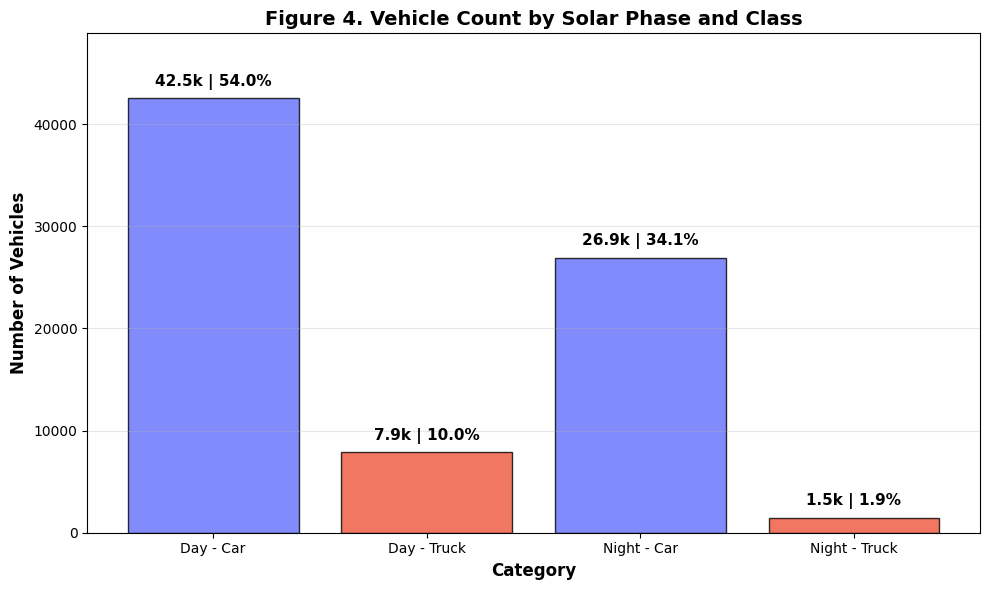

VEHICLE COUNT BY CATEGORY

Total vehicles: 78,748

  Day - Car:     42,517 (54.0%)
  Day - Truck:   7,871 (10.0%)
  Night - Car:   26,890 (34.1%)
  Night - Truck: 1,470 (1.9%)



In [36]:
## Distribution plot
vehicle_count_by_category_bar_chart(final_summary, show_plot=True)

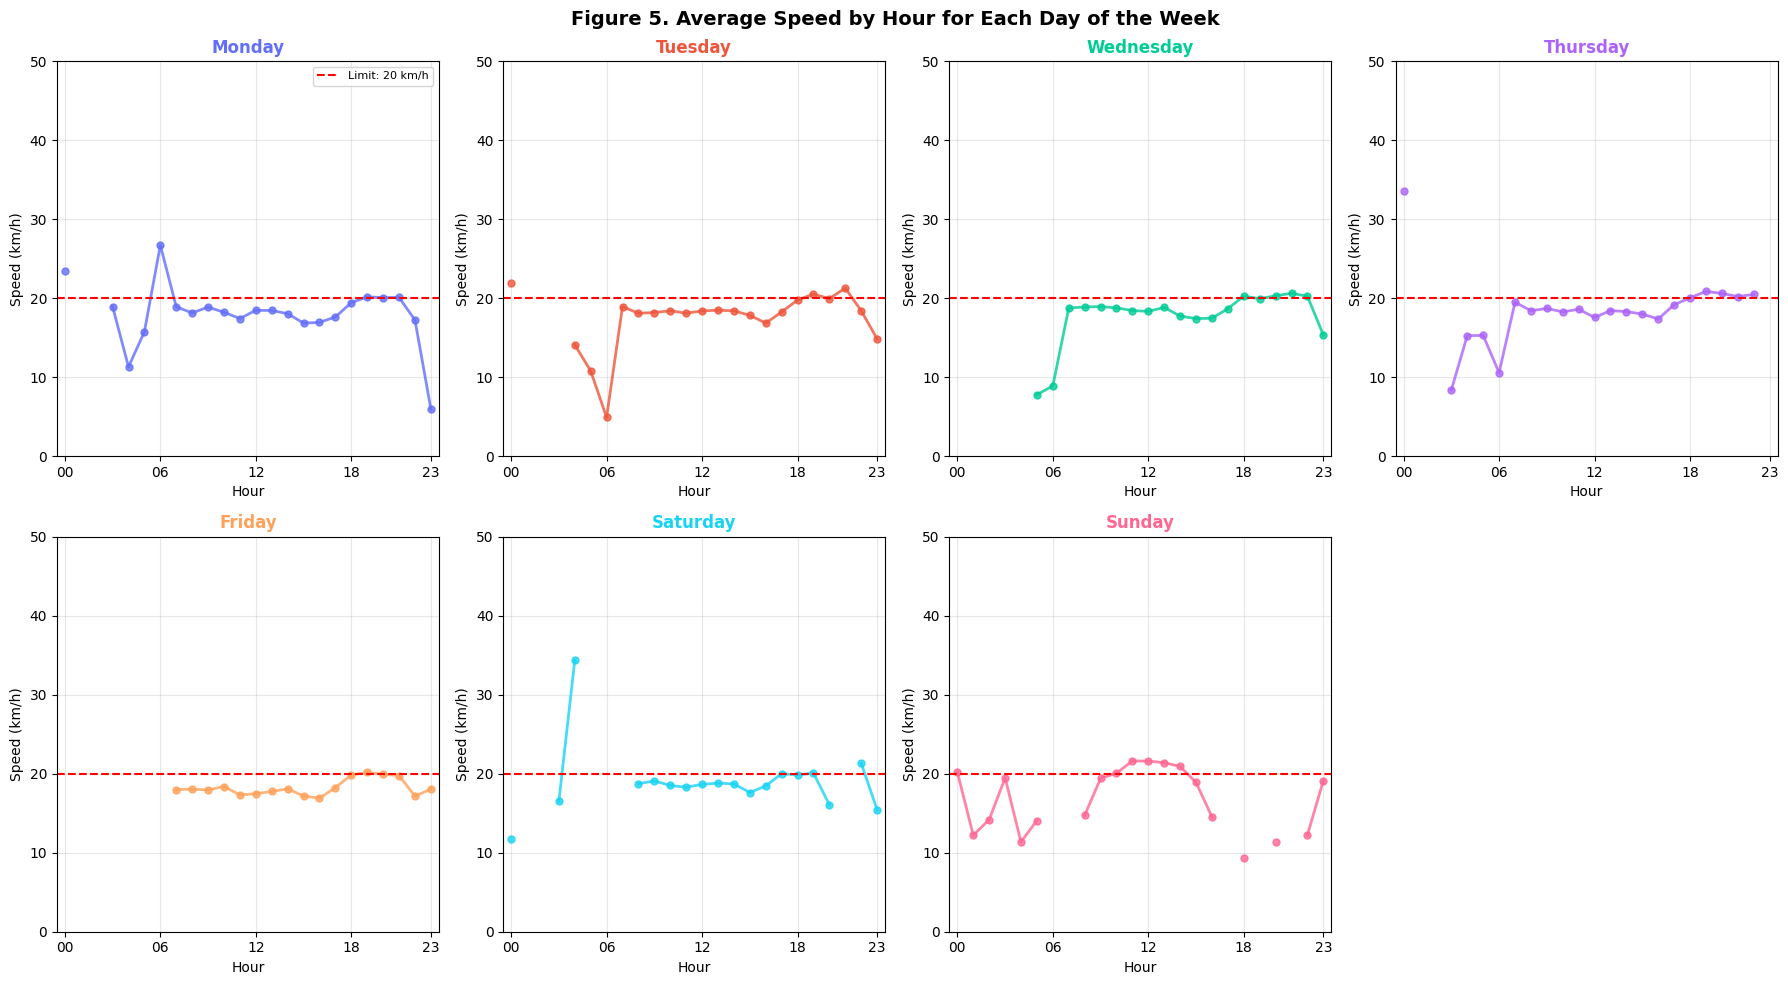

AVERAGE SPEED BY DAY OF WEEK AND HOUR (km/h)

Pivot Table (rows=hour, columns=day of week):
day_of_week  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
hour                                                                       
0             23.42    21.88        NaN     33.52     NaN     11.78   20.20
1               NaN      NaN        NaN       NaN     NaN       NaN   12.22
2               NaN      NaN        NaN       NaN     NaN       NaN   14.19
3             18.95      NaN        NaN      8.39     NaN     16.50   19.47
4             11.31    14.12        NaN     15.27     NaN     34.36   11.38
5             15.77    10.80       7.80     15.30     NaN       NaN   14.08
6             26.72     4.93       8.90     10.57     NaN       NaN     NaN
7             18.92    18.94      18.77     19.50   17.99       NaN     NaN
8             18.14    18.10      18.90     18.43   18.05     18.74   14.74
9             18.88    18.19      18.95     18.71   17.95     19.09   19

In [37]:
## Average speed by weekday and hour
average_speed_by_weekday_and_hour(final_summary, show_plot=True)

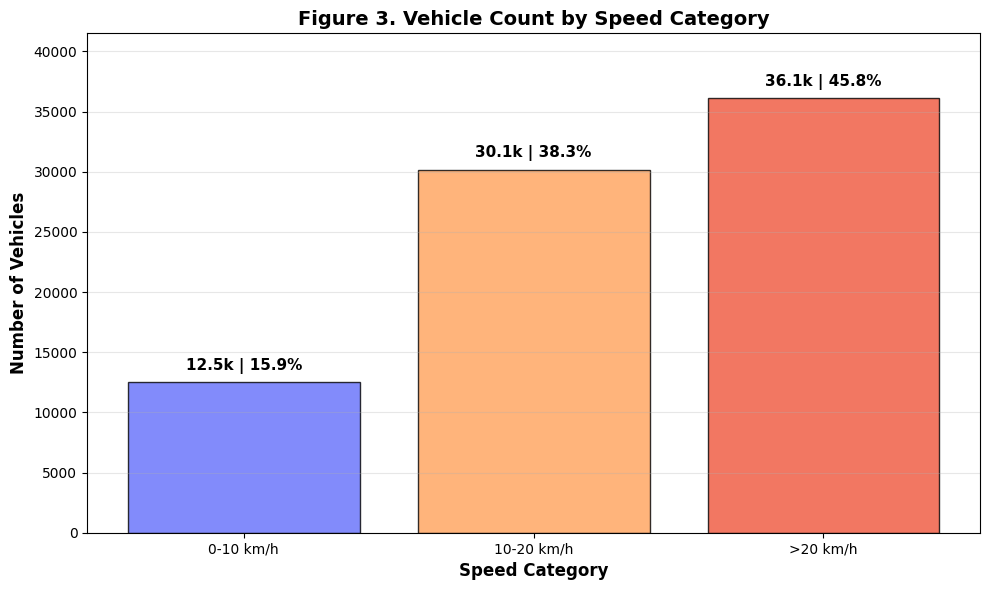

VEHICLE COUNT BY SPEED CATEGORY

Total vehicles: 78,748

  0-10 km/h:   12,508 (15.9%)
  10-20 km/h:  30,147 (38.3%)
  >20 km/h:    36,093 (45.8%)



In [38]:
speed_category_bar_chart(final_summary, show_plot=True)